## 練習測驗：線性迴歸（Linear Regression）

歡迎來到第一個測驗實驗！在這個實驗中，你將要實作「單變數線性迴歸」，用來預測連鎖餐廳在不同城市的獲利。


## 大綱
- [ 1 - 套件（Packages）](#1)
- [ 2 - 單變數線性迴歸 ](#2)
  - [ 2.1 問題說明（Problem Statement）](#2.1)
  - [ 2.2 資料集（Dataset）](#2.2)
  - [ 2.3 線性迴歸複習（Refresher on linear regression）](#2.3)
  - [ 2.4 成本函數計算（Compute Cost）](#2.4)
    - [ 練習 1（Exercise 1）](#ex01)
  - [ 2.5 梯度下降法（Gradient descent）](#2.5)
    - [ 練習 2（Exercise 2）](#ex02)
  - [ 2.6 使用批次梯度下降學習參數（Learning parameters using batch gradient descent）](#2.6)


_**注意：** 為了避免自動評分系統（autograder）出錯，**請不要**編輯或刪除這份 notebook 中「非評分」的程式碼區塊，也請**不要新增**任何新的程式碼儲存格。
**在你順利通過本次作業之後**，如果想對非評分的程式碼進行實驗，可以參考本 notebook 最底部的說明進行調整。_

<a name="1"></a>
## 1 - 套件（Packages）

首先，請執行下方的程式碼儲存格，匯入在本次作業中會用到的所有套件：
- [numpy](https://www.numpy.org)：在 Python 中處理矩陣與向量運算的核心套件。
- [matplotlib](https://matplotlib.org)：常用的繪圖函式庫，用來畫各種圖表。
- `utils.py`：本作業會用到的一些輔助函式都放在這個檔案中，你**不需要**修改裡面的任何程式碼。


In [1]:
# region 資料載入
import copy
import math
import sys, os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

def find_repo_root(marker="README.md"):
    cur = Path.cwd()
    while cur != cur.parent:  # 防止無限迴圈，到達檔案系統根目錄就停
        if (cur / marker).exists():
            return cur
        cur = cur.parent
    return None

def import_data_from_github():
    import urllib.request, shutil
    
    def isRunningInColab() -> bool:
        return "google.colab" in sys.modules

    def isRunningInJupyterLab() -> bool:
        try:
            import jupyterlab
            return True
        except ImportError:
            return False
        
    def detect_env():
        from IPython import get_ipython
        if isRunningInColab():
            return "Colab"
        elif isRunningInJupyterLab():
            return "JupyterLab"
        elif "notebook" in str(type(get_ipython())).lower():
            return "Jupyter Notebook"
        else:
            return "Unknown"
        
    def get_utils_dir(env): 
        if env == "Colab": 
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/utils"
        else:
            return Path.cwd() / "utils"

    def get_data_dir(env): 
        if env == "Colab": 
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/data"
        else:
            return Path.cwd() / "data"

    def get_images_dir(env): 
        if env == "Colab": 
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return f"/content/images"
        else:
            return Path.cwd() / "images"

    env = detect_env()
    UTILS_DIR = get_utils_dir(env)
    DATA_DIR = get_data_dir(env)
    IMG_DIR = get_images_dir(env)

    REPO_DIR = "Machine-Learning-Lab"

    os.makedirs(UTILS_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)
    os.makedirs(IMG_DIR, exist_ok=True)

    BASE = f"https://raw.githubusercontent.com/mz038197/{REPO_DIR}/main"

    utils_list = ["utils.py", "public_tests.py"]
    for u in utils_list:
        urllib.request.urlretrieve(f"{BASE}/utils/{u}", f"{UTILS_DIR}/{u}")

    data_list = ["ex1data1.txt", "ex1data2.txt"]
    for d in data_list:
        urllib.request.urlretrieve(f"{BASE}/data/{d}", f"{DATA_DIR}/{d}")

    # images_list = ["shortRun.PNG", "longRun.PNG", "scale.PNG"]
    # for image in images_list:
    #     urllib.request.urlretrieve(f"{BASE}/lab/teacher/Regression/images/{image}", f"{IMG_DIR}/{image}")

repo_root = find_repo_root()

if repo_root is None:
    import_data_from_github()
    repo_root = Path.cwd()
    
os.chdir(repo_root)
print(f"✅ 切換工作目錄至 {Path.cwd()}")
sys.path.append(str(repo_root)) if str(repo_root) not in sys.path else None
print(f"✅ 加入到系統路徑")

from utils.utils import *

plt.style.use('utils/deeplearning.mplstyle')
print("✅ 匯入模組及設定繪圖樣式")
#endregion 資料載入

✅ 切換工作目錄至 d:\Work\Python\Machine-Learning-Lab
✅ 加入到系統路徑
✅ 匯入模組及設定繪圖樣式


## 2 - 問題說明（Problem Statement）

假設你是一間連鎖餐廳的執行長，正在評估要在哪些城市開設新的分店。
- 你希望將事業擴展到**能帶來較高獲利**的城市。
- 這個連鎖品牌已經在許多城市設有餐廳，並且蒐集了各城市的人口與餐廳獲利資料。
- 此外，你也擁有一些**潛在新據點城市**的資料：
    - 對這些城市，你掌握的是城市人口數。
    
你能否利用這些資料，幫助你判斷**哪些城市比較可能帶來較高的餐廳獲利**？

## 3 - 資料集（Dataset）

你將先從載入本次任務所需的資料開始。
- 下方的 `load_data()` 函式會把資料讀入變數 `x_train` 和 `y_train`：
  - `x_train`：各城市的人口數
  - `y_train`：該城市中餐廳的獲利（若為負值表示虧損）  
  - `x_train` 與 `y_train` 都是 numpy 的陣列。

In [2]:
# load the dataset
x_train, y_train = load_data()

#### 檢視變數內容
在開始實作之前，先熟悉一下資料集是很有幫助的。  
- 一個簡單的方式，就是把每個變數印出來，看它的型態與前幾筆資料。

下面的程式碼會印出變數 `x_train`，以及它的型態。

In [3]:
# print x_train
print("Type of x_train:",type(x_train))
print("First five elements of x_train are:\n", x_train[:5]) 

Type of x_train: <class 'numpy.ndarray'>
First five elements of x_train are:
 [4.6189 4.6254 4.7058 4.7289 4.747 ]


`x_train` 是一個 numpy 陣列，裡面都是大於 0 的小數。 
- 這些數值代表「城市人口數／10,000」。
- 例如：6.1101 代表該城市人口為 61,101 人。
  
接下來，我們來印出 `y_train`。

In [4]:
# print y_train
print("Type of y_train:",type(y_train))
print("First five elements of y_train are:\n", y_train[:5])  

Type of y_train: <class 'numpy.ndarray'>
First five elements of y_train are:
 [ 2.8203  0.6921 -1.3984  1.3949  2.384 ]


同樣地，`y_train` 也是一個 numpy 陣列，包含正值與負值的小數。
- 這些數值代表該城市餐廳的「平均每月獲利」，單位是 \$10,000（也就是一萬美元）。
  - 例如：17.592 代表該城市平均每月獲利 \$175,920。
  - -2.6807 則代表該城市平均每月虧損 \$26,807。

#### 檢查變數的維度（dimensions）

另一個熟悉資料的好方法，是觀察各變數的「維度」（shape）。

請印出 `x_train` 與 `y_train` 的 shape，看看這個資料集中共有多少筆訓練樣本。

In [5]:
print ('The shape of x_train is:', x_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(x_train))

The shape of x_train is: (97,)
The shape of y_train is:  (97,)
Number of training examples (m): 97


城市人口的陣列共有 97 筆資料，月平均獲利的陣列也有 97 筆資料。這兩個變數都是 NumPy 的一維（1D）陣列。

#### 視覺化你的資料

用圖像來呈現資料，常常有助於理解其結構與關係。
- 對這個資料集來說，只包含兩個變數（獲利與人口），因此可以用散佈圖（scatter plot）來視覺化。
- 在真實世界的問題中，通常會有兩個以上的特徵（例如：人口、家庭平均收入、每月獲利、每月銷售額等）。就算有多個特徵，你仍可以用散佈圖來觀察「任兩個特徵」之間的關係。

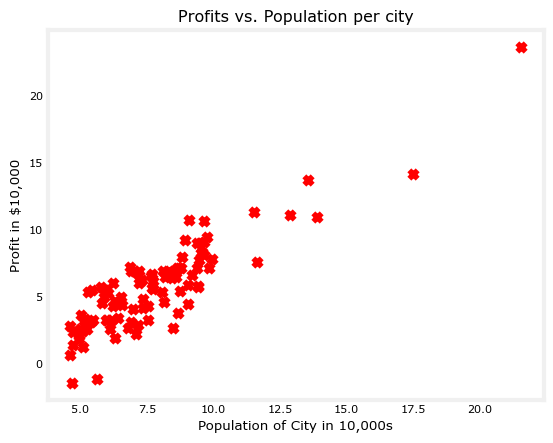

In [6]:
# Create a scatter plot of the data. To change the markers to red "x",
# we used the 'marker' and 'c' parameters
plt.scatter(x_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Profits vs. Population per city")
# Set the y-axis label
plt.ylabel('Profit in $10,000')
# Set the x-axis label
plt.xlabel('Population of City in 10,000s')
plt.show()

你的目標是建立一個線性迴歸模型，使其能夠良好地擬合這筆資料。
- 有了這個模型之後，只要輸入某個新城市的人口，就可以估計在該城市開設餐廳時的「每月獲利」可能是多少。

<a name="4"></a>
## 4 - 線性迴歸複習（Refresher on linear regression）

在這個練習實驗中，你會為資料集擬合線性迴歸模型的參數 $(w,b)$。
- 單變數線性迴歸的模型函數會把輸入 `x`（城市人口）映射到輸出 `y`（該城市餐廳的每月獲利），可以寫成：
    $$f_{w,b}(x) = wx + b$$
    

- 要訓練一個線性迴歸模型，就是要找到一組最適合資料的參數 $(w,b)$。

    - 為了比較不同 $(w,b)$ 的好壞，我們會定義一個成本函數（cost function）$J(w,b)$。
      - $J$ 是 $(w,b)$ 的函數，也就是說，成本 $J(w,b)$ 的數值取決於你選擇的參數 $(w,b)$。
  
    - 那組「最適合」資料的 $(w,b)$，就是讓成本函數 $J(w,b)$ 最小的那一組參數。


- 為了找出能讓成本 $J(w,b)$ 最小的參數 $(w,b)$，我們會使用一種方法：**梯度下降（gradient descent）**。
  - 梯度下降每走一步，就會更新一次 $(w,b)$，讓它們越來越接近讓成本函數最小的最佳值。
  

- 訓練完成後的線性迴歸模型，可以接收輸入特徵 $x$（城市人口），並輸出對應的預測值 $f_{w,b}(x)$（預測在該城市的餐廳每月獲利）。

<a name="5"></a>
## 5 - 成本函數計算（Compute Cost）

梯度下降法會重複地更新參數 $(w,b)$，讓成本函數 $J(w,b)$ 逐步變小。
- 在每一步更新 $(w,b)$ 之後，如果能計算當前的成本 $J(w,b)$，就能觀察訓練是否朝正確方向進行。
- 在本節中，你會實作一個函式來計算 $J(w,b)$，方便你檢查梯度下降演算法的執行情況。

#### 成本函數（Cost function）
你在課程中應該已經看過，對單一變數線性迴歸而言，成本函數 $J(w,b)$ 定義如下：

$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$$ 

- 你可以把 $f_{w,b}(x^{(i)})$ 想成：模型對第 $i$ 筆資料的「預測獲利」，而 $y^{(i)}$ 則是資料中實際記錄的「真實獲利」。
- 其中 $m$ 是資料集中訓練樣本的數量。

#### 模型預測（Model prediction）

- 對於單變數線性迴歸，第 $i$ 筆樣本的模型預測值 $f_{w,b}(x^{(i)})$ 可以寫成：

$$ f_{w,b}(x^{(i)}) = wx^{(i)} + b$$

這就是一條直線的方程式，其中 $b$ 是截距（intercept），$w$ 是斜率（slope）。

#### 實作說明（Implementation）

請完成下方的 `compute_cost()` 函式，計算成本函數 $J(w,b)$。

<a name="ex01"></a>
### 練習 1（Exercise 1）

請完成下面的 `compute_cost` 函式，讓它能夠：

* 針對每一筆訓練資料進行迴圈，並且計算：
    * 該筆資料的模型預測值：
    $$
    f_{wb}(x^{(i)}) =  wx^{(i)} + b 
    $$
   
    * 該筆資料對應的成本：
    $$cost^{(i)} =  (f_{wb} - y^{(i)})^2$$
    

* 回傳所有樣本的總成本：
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} cost^{(i)}$$
  * 其中，$m$ 為訓練樣本數量，$\sum$ 則為求和符號。

如果卡住了，你可以參考此儲存格後面提供的提示來完成實作。

In [ ]:
# UNQ_C1
# GRADED FUNCTION: compute_cost

def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
        x (ndarray): Shape (m,) Input to the model (Population of cities) 
        y (ndarray): Shape (m,) Label (Actual profits for the cities)
        w, b (scalar): Parameters of the model
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    # You need to return this variable correctly
    total_cost = 0
    
    ### START CODE HERE ###
    
    ### END CODE HERE ### 

    return total_cost

<details>
  <summary><font size="3" color="darkgreen"><b>點此展開提示</b></font></summary>
    
   * 你可以用下列程式碼來表示一個求和運算，例如：$h = \sum\limits_{i = 0}^{m-1} 2i$
    
    ```python 
    h = 0
    for i in range(m):
        h = h + 2*i
    ```
  
   * 在這個問題中，你可以用 `for` 迴圈走過 `x` 中的每一筆資料，並在每次迭代中把對應的 `cost` 加到一個在迴圈外初始化的變數 `cost_sum` 中。

   * 最後，將 `cost_sum` 除以 `2m`，就可以得到 `total_cost`。
   * 如果你是 Python 新手，請確認你的縮排（空白或 tab）是一致的；否則可能會得到錯誤的結果，或出現 `IndentationError: unexpected indent`。你可以參考社群中的這篇說明：[這個主題](https://community.deeplearning.ai/t/indentation-in-python-indentationerror-unexpected-indent/159398)。

    <details>
          <summary><font size="2" color="darkblue"><b> 點此獲得更多提示</b></font></summary>
        
    * 以下是這個函式的一種實作架構：
    
    ```python 
    def compute_cost(x, y, w, b):
        # 訓練樣本數
        m = x.shape[0] 
    
        # 需正確回傳的變數
        total_cost = 0
    
        ### START CODE HERE ###  
        # 用來累加每個樣本成本的變數
        cost_sum = 0
    
        # 走過每一筆訓練資料
        for i in range(m):
            # 這裡填入第 i 筆資料的預測值 f_wb
            f_wb = 
            # 這裡填入第 i 筆資料的成本 cost
            cost = 
        
            # 累加成本
            cost_sum = cost_sum + cost 

        # 將總和除以 (2*m) 得到最終成本
        total_cost = (1 / (2 * m)) * cost_sum
        ### END CODE HERE ### 

        return total_cost
    ```
    
    * 如果還是卡住，你可以再看下面關於如何計算 `f_wb` 與 `cost` 的提示。
    
    <details>
          <summary><font size="2" color="darkblue"><b>關於如何計算 f_wb 的提示</b></font></summary>
           &emsp; &emsp; 對於純量 $a$、$b$、$c$（這裡的 <code>x[i]</code>、<code>w</code>、<code>b</code> 都是純量），若要計算 $h = ab + c$，可以寫成 <code>h = a * b + c</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; 更多關於 f 的提示</b></font></summary>
               &emsp; &emsp; 你可以這樣計算 f_wb：<code>f_wb = w * x[i] + b </code>
           </details>
    </details>

     <details>
          <summary><font size="2" color="darkblue"><b>關於如何計算 cost 的提示</b></font></summary>
          &emsp; &emsp; 若要計算變數 z 的平方，可以寫成 <code>z**2</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; 更多關於 cost 的提示</b></font></summary>
              &emsp; &emsp; 你可以這樣計算 cost：<code>cost = (f_wb - y[i]) ** 2</code>
          </details>
    </details>
        
    </details>

</details>

    


你可以執行下面的測試程式碼，檢查自己實作的結果是否正確：

In [ ]:
# Compute cost with some initial values for paramaters w, b
initial_w = 2
initial_b = 1

cost = compute_cost(x_train, y_train, initial_w, initial_b)
print(type(cost))
print(f'Cost at initial w: {cost:.3f}')

# Public tests
from utils.public_tests import *
compute_cost_test(compute_cost)

**預期輸出（Expected Output）**：
<table>
  <tr>
    <td> <b>Cost at initial w:<b> 62.639 </td> 
  </tr>
</table>

<a name="6"></a>
## 6 - 梯度下降法（Gradient descent） 

在本節中，你將為線性迴歸實作參數 $w, b$ 的梯度計算函式。 

在課程影片中，我們介紹了梯度下降演算法，其形式如下：

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & \phantom {0000} b := b -  \alpha \frac{\partial J(w,b)}{\partial b} \newline       \; & \phantom {0000} w := w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{1}  \; & 
\newline & \rbrace\end{align*}$$

在這裡，參數 $w, b$ 會同時更新，其中  
$$
\frac{\partial J(w,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{2}
$$
$$
\frac{\partial J(w,b)}{\partial w}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) -y^{(i)})x^{(i)} \tag{3}
$$
* 其中，$m$ 是訓練樣本的數量。

    
*  $f_{w,b}(x^{(i)})$ 是模型對第 $i$ 筆資料的預測值，而 $y^{(i)}$ 則是該筆資料的真實值。


接下來，你將實作一個名為 `compute_gradient` 的函式，用來計算 $\frac{\partial J(w,b)}{\partial w}$ 與 $\frac{\partial J(w,b)}{\partial b}$。

<a name="ex02"></a>
### 練習 2（Exercise 2）

請完成 `compute_gradient` 函式，讓它能夠：

* 對每一筆訓練資料進行迴圈，並在每筆資料上計算：
    * 該筆資料的模型預測值：
    $$
    f_{wb}(x^{(i)}) =  wx^{(i)} + b 
    $$
   
    * 該筆資料對應的梯度：
        $$
        \frac{\partial J(w,b)}{\partial b}^{(i)}  =  (f_{w,b}(x^{(i)}) - y^{(i)}) 
        $$
        $$
        \frac{\partial J(w,b)}{\partial w}^{(i)}  =  (f_{w,b}(x^{(i)}) -y^{(i)})x^{(i)} 
        $$
    

* 回傳對所有樣本求和後的總梯度：
    $$
    \frac{\partial J(w,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} \frac{\partial J(w,b)}{\partial b}^{(i)}
    $$
    
    $$
    \frac{\partial J(w,b)}{\partial w}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} \frac{\partial J(w,b)}{\partial w}^{(i)} 
    $$
  * 其中，$m$ 是訓練樣本的數量，$\sum$ 表示加總運算。

如果遇到困難，你可以參考此儲存格後方的提示來協助完成實作。

In [ ]:
# UNQ_C2
# GRADED FUNCTION: compute_gradient
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray): Shape (m,) Input to the model (Population of cities) 
      y (ndarray): Shape (m,) Label (Actual profits for the cities)
      w, b (scalar): Parameters of the model  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]
    
    # You need to return the following variables correctly
    dj_dw = 0
    dj_db = 0
    
    ### START CODE HERE ###
    
    ### END CODE HERE ### 
        
    return dj_dw, dj_db

<details>
  <summary><font size="3" color="darkgreen"><b>點此展開提示</b></font></summary>
    
   * 你可以用下列程式碼來表示一個求和運算，例如：$h = \sum\limits_{i = 0}^{m-1} 2i$
    
   ```python 
    h = 0
    for i in range(m):
        h = h + 2*i
   ```
    
   * 在這個問題中，你可以用 `for` 迴圈走過 `x` 中的每一筆資料，並在每次迭代中把該筆資料貢獻的梯度加入到在迴圈外初始化的變數 `dj_dw` 和 `dj_db` 中。

   * 最後，將 `dj_dw` 與 `dj_db` 都除以 `m`，就可以得到平均梯度。    
    <details>
          <summary><font size="2" color="darkblue"><b> 點此獲得更多提示</b></font></summary>
        
    * 以下是這個函式的一種實作架構：
    
    ```python 
    def compute_gradient(x, y, w, b): 
        """
        Computes the gradient for linear regression 
        Args:
          x (ndarray): Shape (m,) Input to the model (Population of cities) 
          y (ndarray): Shape (m,) Label (Actual profits for the cities)
          w, b (scalar): Parameters of the model  
        Returns
          dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
          dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
        """
    
        # Number of training examples
        m = x.shape[0]
    
        # You need to return the following variables correctly
        dj_dw = 0
        dj_db = 0
    
        ### START CODE HERE ### 
        # Loop over examples
        for i in range(m):  
            # Your code here to get prediction f_wb for the ith example
            f_wb = 
            
            # Your code here to get the gradient for w from the ith example 
            dj_dw_i = 
        
            # Your code here to get the gradient for b from the ith example 
            dj_db_i = 
     
            # Update dj_db : In Python, a += 1  is the same as a = a + 1
            dj_db += dj_db_i
        
            # Update dj_dw
            dj_dw += dj_dw_i
    
        # Divide both dj_dw and dj_db by m
        dj_dw = dj_dw / m
        dj_db = dj_db / m
        ### END CODE HERE ### 
        
        return dj_dw, dj_db
    ```
        
    * If you're still stuck, you can check the hints presented below to figure out how to calculate `f_wb` and `cost`.
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate f_wb</b></font></summary>
           &emsp; &emsp; You did this in the previous exercise! For scalars $a$, $b$ and $c$ (<code>x[i]</code>, <code>w</code> and <code>b</code> are all scalars), you can calculate the equation $h = ab + c$ in code as <code>h = a * b + c</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f</b></font></summary>
               &emsp; &emsp; You can compute f_wb as <code>f_wb = w * x[i] + b </code>
           </details>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate dj_dw_i</b></font></summary>
           &emsp; &emsp; For scalars $a$, $b$ and $c$ (<code>f_wb</code>, <code>y[i]</code> and <code>x[i]</code> are all scalars), you can calculate the equation $h = (a - b)c$ in code as <code>h = (a-b)*c</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f</b></font></summary>
               &emsp; &emsp; You can compute dj_dw_i as <code>dj_dw_i = (f_wb - y[i]) * x[i] </code>
           </details>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate dj_db_i</b></font></summary>
             &emsp; &emsp; You can compute dj_db_i as <code> dj_db_i = f_wb - y[i] </code>
    </details>
        
    </details>

</details>

    


請執行下面幾個程式儲存格，用兩組不同的初始參數 $w, b$ 來檢查你實作的 `compute_gradient` 函式是否正確。

In [ ]:
# Compute and display gradient with w initialized to zeroes
initial_w = 0
initial_b = 0

tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, initial_w, initial_b)
print('Gradient at initial w, b (zeros):', tmp_dj_dw, tmp_dj_db)

compute_gradient_test(compute_gradient)

接著，我們來看看上述梯度計算在資料集上的表現。

**預期輸出（Expected Output）**：
<table>
  <tr>
    <td> <b>Gradient at initial , b (zeros)<b></td>
    <td> -52.75525517 -5.755579029597324</td> 
  </tr>
</table>

In [ ]:
# Compute and display cost and gradient with non-zero w
test_w = 0.2
test_b = 0.2
tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, test_w, test_b)

print('Gradient at test w, b:', tmp_dj_dw, tmp_dj_db)

**預期輸出（Expected Output）**：
<table>
  <tr>
    <td> <b>Gradient at test w<b></td>
    <td> -37.64212915 -3.9946491237151696</td> 
  </tr>
</table>

<a name="2.6"></a>
### 2.6 使用批次梯度下降學習參數 

接下來，你將利用「批次梯度下降」（batch gradient descent）來尋找線性迴歸模型的最適參數。
- 這裡的 batch 指的是：**每次更新參數時，都使用所有訓練樣本**。
- 這一節你不需要自己寫程式，只要執行下面幾個儲存格即可。

- 檢查梯度下降是否運作正常的一個好方法，是觀察每一步的成本值 $J(w,b)$，看看它是否在持續下降。

- 在你正確實作梯度與成本函數，並且選擇合適的學習率（learning rate） $\alpha$ 的情況下，$J(w,b)$ 不應該上升，且會在演算法結束前逐漸收斂到一個穩定的值。

In [ ]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

In [ ]:
# initialize fitting parameters. Recall that the shape of w is (n,)
initial_w = 0.
initial_b = 0.

# some gradient descent settings
iterations = 1500
alpha = 0.01

w,b,_,_ = gradient_descent(x_train ,y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha, iterations)
print("w,b found by gradient descent:", w, b)

**Expected Output**:
<table>
  <tr>
    <td> <b> w, b found by gradient descent<b></td>
    <td> 1.05983782 -2.4432608811085865</td> 
  </tr>
</table>

現在我們將利用梯度下降得到的最終參數來繪製線性擬合直線。

回顧一下，對於單一一筆樣本，其預測值可以寫成 $f(x^{(i)})= wx^{(i)}+b$。

若要計算整個資料集中所有樣本的預測值，我們可以對所有訓練樣本進行迴圈，逐一計算每筆資料的預測結果，下方程式碼示範了這個做法。

In [ ]:
m = x_train.shape[0]
predicted = np.zeros(m)

for i in range(m):
    predicted[i] = w * x_train[i] + b

接著，我們會把這些預測值畫出來，與原始資料點一起顯示，以觀察線性擬合的效果。

In [ ]:
# Plot the linear fit
plt.plot(x_train, predicted, c = "b")

# Create a scatter plot of the data. 
plt.scatter(x_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Profits vs. Population per city")
# Set the y-axis label
plt.ylabel('Profit in $10,000')
# Set the x-axis label
plt.xlabel('Population of City in 10,000s')

你得到的最終參數 $w,b$ 也可以用來對新的城市進行獲利預測。下面我們估計人口為 35,000 與 70,000 的地區，其預期獲利為多少。

- 這個模型的輸入是「城市人口（單位：10,000 人）」。

- 因此，35,000 人可轉換為輸入 `np.array([3.5])`。

- 同樣地，70,000 人可轉換為輸入 `np.array([7.])`。


In [ ]:
predict1 = 3.5 * w + b
print('For population = 35,000, we predict a profit of $%.2f' % (predict1*10000))

predict2 = 7.0 * w + b
print('For population = 70,000, we predict a profit of $%.2f' % (predict2*10000))

**預期輸出（Expected Output）**：
<table>
  <tr>
    <td> <b> For population = 35,000, we predict a profit of<b></td>
    <td> $12661.71 </td> 
  </tr>
  
  <tr>
    <td> <b> For population = 70,000, we predict a profit of<b></td>
    <td> $49756.04 </td> 
  </tr>
</table>

**恭喜你完成這個線性迴歸的練習實驗！下一週，你將學習如何建立模型來解決另一種問題：分類問題（classification）。期待再見到你！**

<details>
  <summary><font size="2" color="darkgreen"><b>如果你想對「非評分」程式碼做實驗，請點此展開說明。</b></font></summary>
    <p><i><b>重要提醒：為了避免影響自動評分，建議在你已經通過本作業之後再做以下調整。</b></i>
    <ol>
        <li> 在上方功能表中，點選「View」→「Cell Toolbar」→「Edit Metadata」</li>
        <li> 在你想鎖定／解鎖的程式碼儲存格旁，按下「Edit Metadata」按鈕</li>
        <li> 將該儲存格的 "editable" 屬性設為：
            <ul>
                <li> 設為 "true" 代表解鎖，可自由編輯 </li>
                <li> 設為 "false" 代表鎖定，不可編輯 </li>
            </ul>
        </li>
        <li> 完成後，在選單中點「View」→「Cell Toolbar」→「None」，關閉工具列顯示 </li>
    </ol>
    <p> 下圖是上述步驟的簡短示範： 
        <br>
        <img src="https://lh3.google.com/u/0/d/14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>